## $I. Load Dataset:$

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

In [ ]:
#As previous report, we figure out 5 mong hundreds of codes. In this report, we chose VSN for the test:
path = '/content/gdrive/MyDrive/L/Data/df_VSN.csv'
df_VSN = pd.read_csv(path)
df_VSN.head()

,code,snapshot_date,open,high,low,close,nmVolume
0,VSN,2017-01-03,48.6,49.8,48.0,49.7,7500.0
1,VSN,2017-01-04,48.0,48.1,48.0,48.0,3200.0
2,VSN,2017-01-05,47.0,48.0,45.0,45.0,16900.0
3,VSN,2017-01-06,45.0,46.4,44.0,44.9,11800.0
4,VSN,2017-01-09,46.0,46.0,46.0,46.0,100.0


In [ ]:
df_VSN['snapshot_date'] = pd.to_datetime(df_VSN['snapshot_date'])

In [ ]:
df_VSN.shape

(1252, 7)

## $II. Preparation for Arima Model:$

In [ ]:
#Check Stationary for each code:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(df):
    result = adfuller(df.close)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")
check_stationarity(df_VSN)
#With the Non-stationary, differencing is important

ADF Statistic: -1.989259
p-value: 0.291302
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Non-stationary


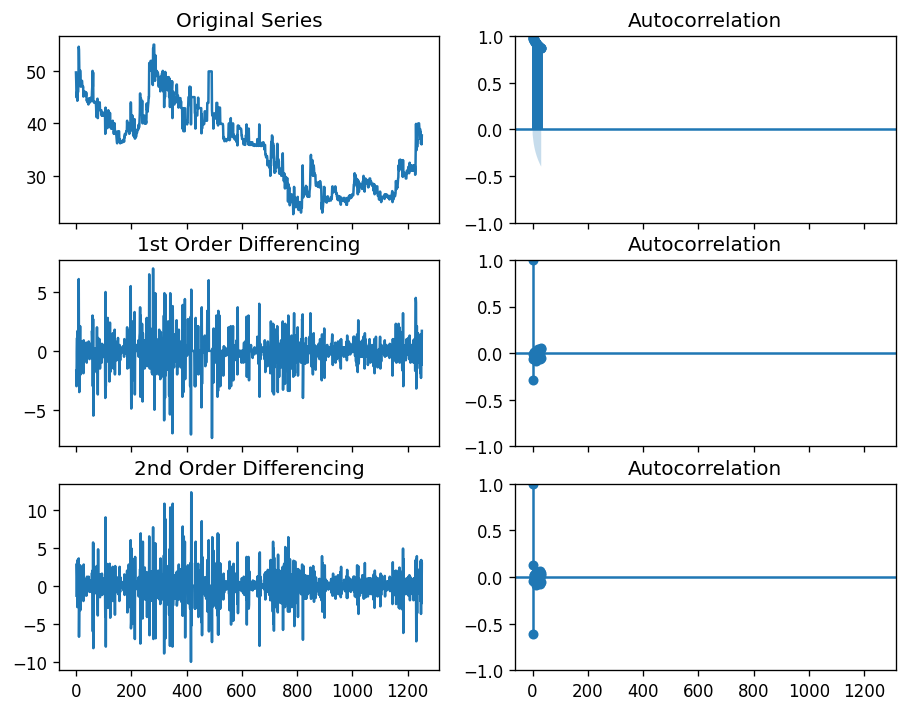

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})


# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df_VSN.close); axes[0, 0].set_title('Original Series')
plot_acf(df_VSN.close, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df_VSN.close.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df_VSN.close.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df_VSN.close.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df_VSN.close.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

<Figure size 1800x960 with 0 Axes>

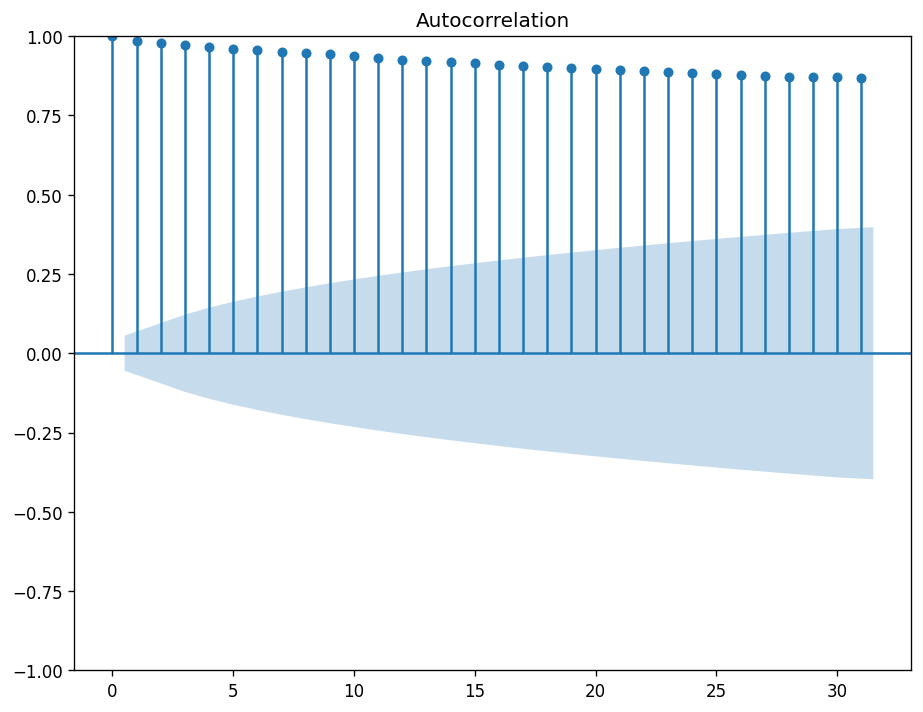

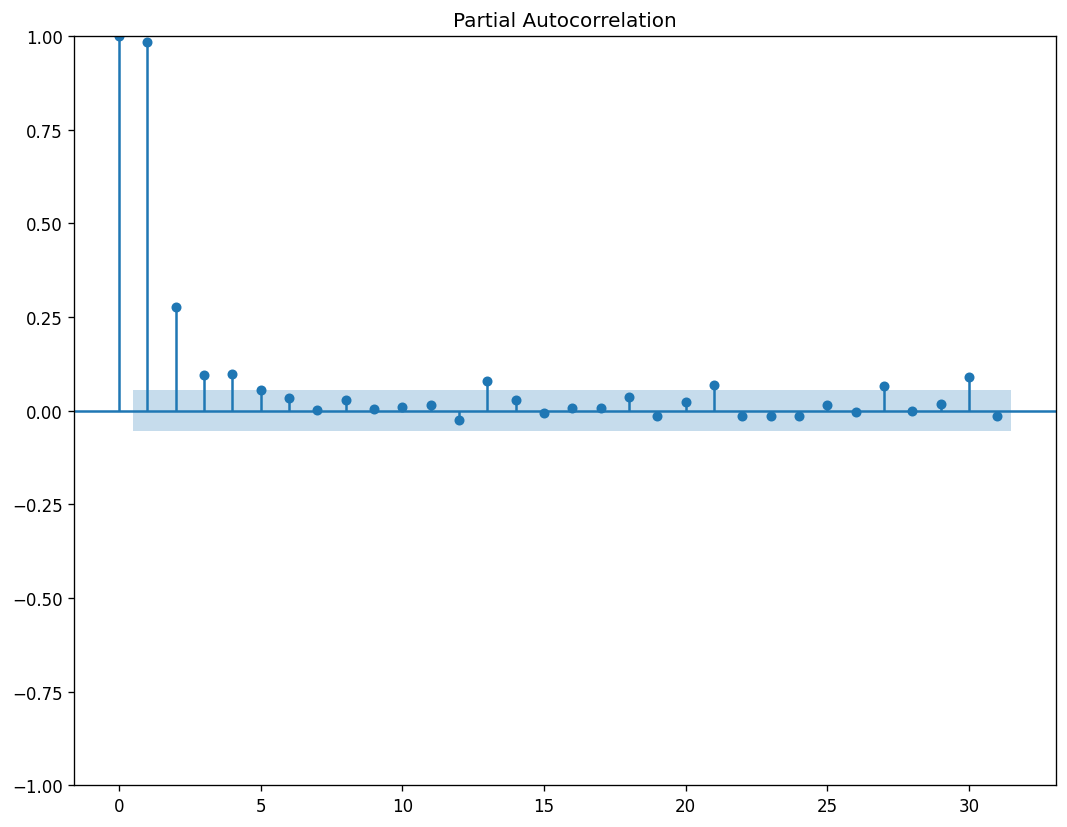

In [ ]:
#ACF and PACF plot for 5 codes: 
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

def acf_pacf(sample): 
  plt.figure(figsize = (15,8))
  plot_acf(sample['close'])
  plot_pacf(sample['close'], method='ols')
  plt.tight_layout()
  plt.show()
acf_pacf(df_VSN)

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


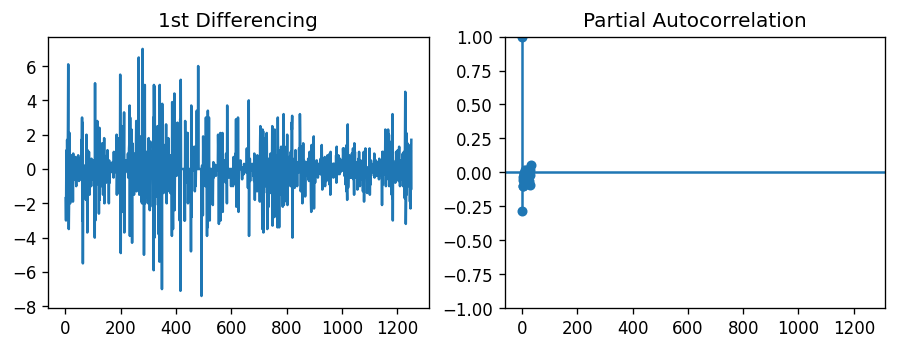

In [ ]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df_VSN.close.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df_VSN.close.diff().dropna(), ax=axes[1])

plt.show()


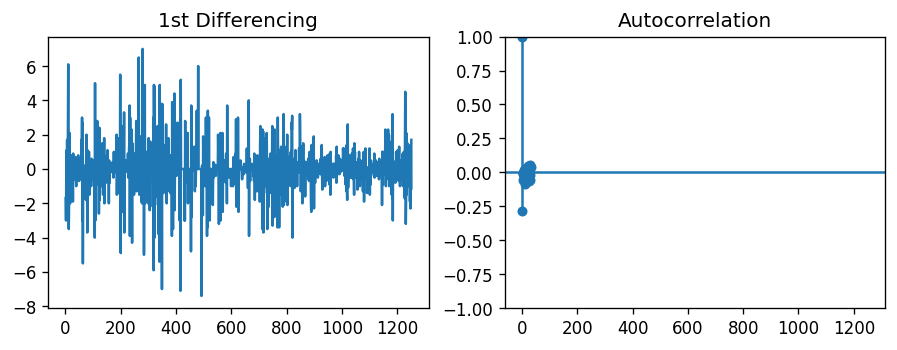

In [ ]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df_VSN.close.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df_VSN.close.diff().dropna(), ax=axes[1])

plt.show()

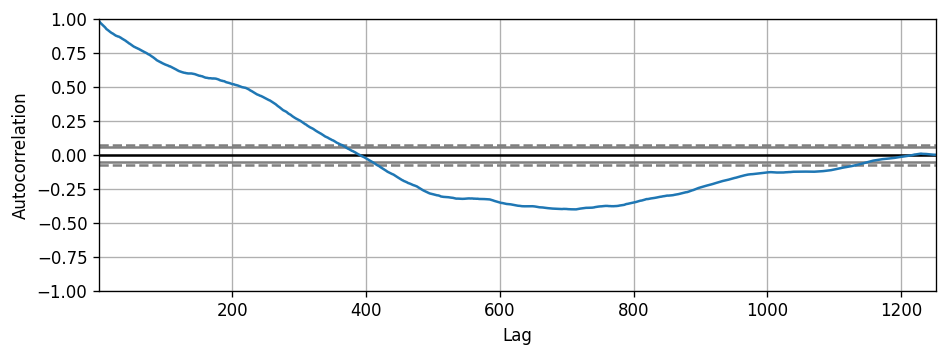

In [ ]:
#Autocorr plot: 
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df_VSN['close'])
plt.show()

In [ ]:
#Import pmdarima model:
! pip install pmdarima 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pmdarima.arima import auto_arima

In [ ]:
# Series = df_VSN[['snapshot_date','close']]
# Series = Series.set_index(['snapshot_date'])

In [ ]:
#Train & Test split:
train = df_VSN[:1238]
test = df_VSN[1239:]

In term of Arima model, defining 3 indexes p,d q is vital. What, and why p,d,q

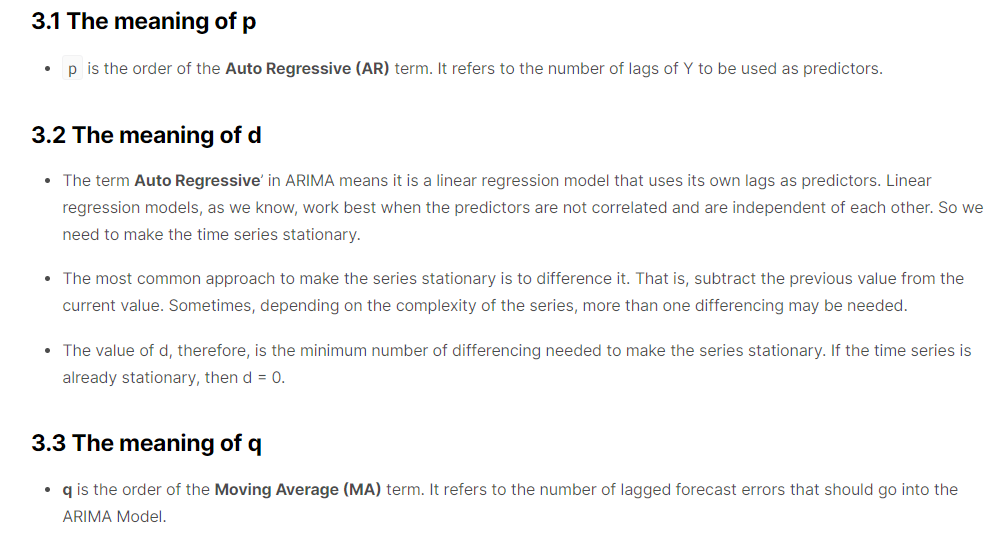

In [ ]:
#The auto Arima will automatically defining the best model:

from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = pm.auto_arima(train['close'], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=10, max_q=10, # maximum p and q
                      m=365,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())
#BEST model was: ARIMA(1,1,2)(0,0,0)[0]  

/usr/local/lib/python3.9/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (365) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4084.158, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4211.129, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4111.324, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4089.785, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4209.182, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4082.327, Time=2.19 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4100.139, Time=0.23 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4084.301, Time=2.62 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4084.201, Time=1.51 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4081.362, Time=1.91 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4086.691, Time=0.29 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4084.448, Time=0.91 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4082.678, Time=0.38 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4085.027, Time=4.90 sec
 ARIMA(1,1,2)(0,0,0)[0]          

We decided to apply the Auto Arima model, which will automatically choose the most proper index for ARIMA

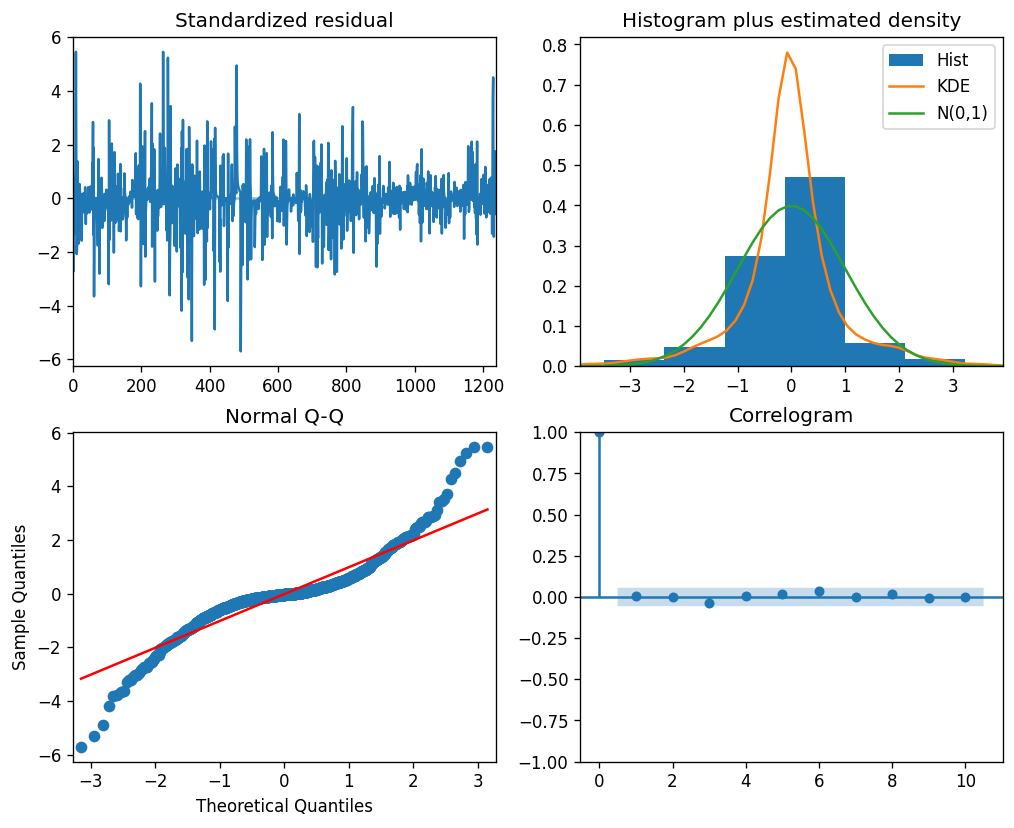

In [ ]:
model.plot_diagnostics(figsize=(10,8))
plt.show()

***Interpretation of plots in plot diagnostics:***

**Standardized residual:** The residual errors seem to fluctuate around a mean of zero and have a uniform variance.

**Histogram:** The density plot suggest normal distribution with mean slighlty shifted towards right.

**Theoretical Quantiles:** Mostly the dots fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.

**Correlogram:** The Correlogram, (or ACF plot) shows the residual errors are not autocorrelated. The ACF plot would imply that there is some pattern in the residual errors which are not explained in the model. So we will need to look for more X’s (predictors) to the model.

In [ ]:
predict = pd.DataFrame(model.predict(n_periods = 365),index = test.index)
predict.columns = ['close']

#daily period so we may test with n_per = 12(monthly), 365(daily) or 1(yearly).

In [ ]:
predict.head()

,close
1239,37.852501
1240,37.657663
1241,37.496789
1242,37.363959
1243,37.254285


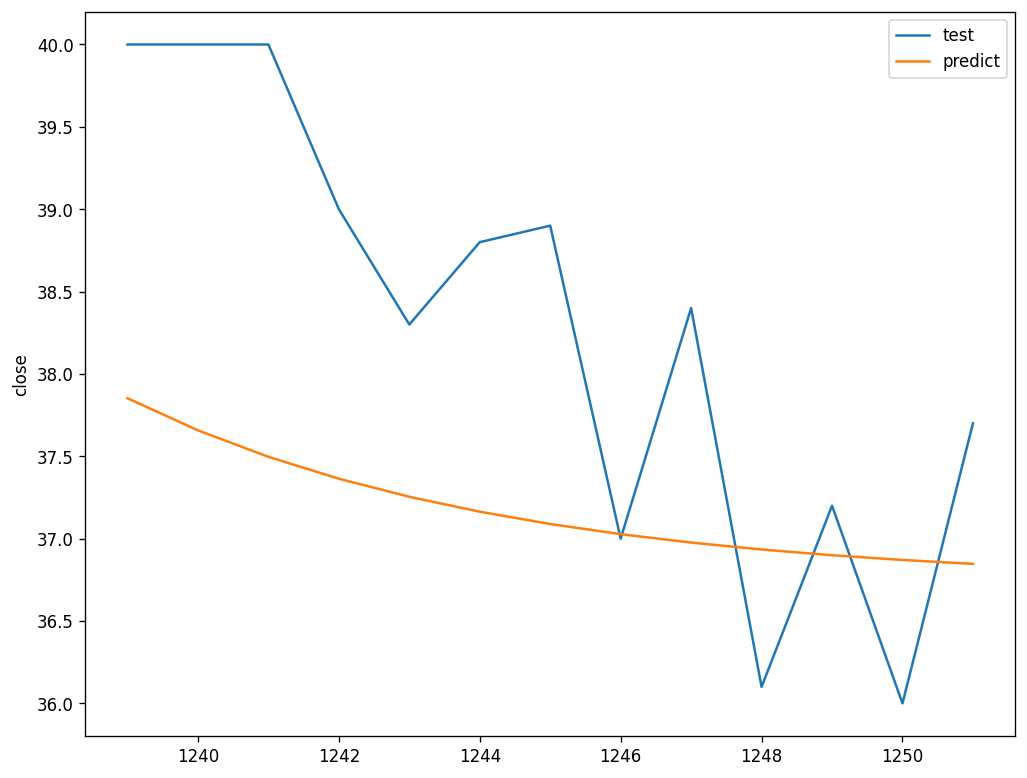

In [ ]:
#Plot for train, test and predict price: 

plt.figure(figsize = (10,8))

sns.lineplot(data = test, x = test.index, y = 'close',label = 'test')
sns.lineplot(data = predict, x = predict.index, y='close',label = 'predict')
plt.show()

It seems like the prediction is not good.

In [ ]:
from sklearn.metrics import r2_score
r2_score(test['close'], predict['close']) #Some trouble

-0.3127617276197441

The commonly used accuracy metrics to judge forecasts are:

1. Mean Absolute Percentage Error (MAPE)
2. Mean Error (ME)
3. Mean Absolute Error (MAE)
4. Mean Percentage Error (MPE)
5. Root Mean Squared Error (RMSE)
6. Correlation between the Actual and the Forecast (corr)

Typically, 3 main metrics that are usually used are: MAPE, CORR and MINMAX.

In [ ]:
print('mape = ',np.mean(np.abs(predict.close - test.close)/np.abs(test.close)))
print('me = ', np.mean(predict.close - test.close))
print('mae = ', np.mean(np.abs(predict.close - test.close)))
print('mpe = ', np.mean((predict.close - test.close)/test.close))
print('rmse = ', np.mean((predict.close - test.close)**2)**.5)
print('corr = ', np.corrcoef(predict.close, test.close)[0,1])
mins = np.amin(np.hstack([predict.close[:,None], test.close[:,None]]))
maxs = np.amax(np.hstack([predict.close[:,None], 
                              test.close[:,None]]))
minmax = 1 - np.mean(mins/maxs)    
print('minmax = ',minmax)

mape =  0.03450916644158634
me =  -1.074407544532896
mae =  1.3408865921085042
mpe =  -0.02711999008814152
rmse =  1.5289876945500351
corr =  0.8407870222875322
minmax =  0.09999999999999998


<ipython-input-132-dc540c1f81ab>:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mins = np.amin(np.hstack([predict.close[:,None], test.close[:,None]]))
<ipython-input-132-dc540c1f81ab>:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  maxs = np.amax(np.hstack([predict.close[:,None],
<ipython-input-132-dc540c1f81ab>:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  test.close[:,None]]))


In [ ]:
# # Accuracy metrics
# def forecast_accuracy(forecast, actual):
#     mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
#     me = np.mean(forecast - actual)             # ME
#     mae = np.mean(np.abs(forecast - actual))    # MAE
#     mpe = np.mean((forecast - actual)/actual)   # MPE
#     rmse = np.mean((forecast - actual)**2)**.5  # RMSE
#     corr = np.corrcoef(forecast, actual)[0,1]   # corr
#     mins = np.amin(np.hstack([forecast[:,None], 
#                               actual[:,None]]), axis=1)
#     maxs = np.amax(np.hstack([forecast[:,None], 
#                               actual[:,None]]), axis=1)
#     minmax = 1 - np.mean(mins/maxs)             # minmax
#     acf1 = acf(fc-test)[1]                      # ACF1
#     return({'mape':mape, 'me':me, 'mae': mae, 
#             'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
#             'corr':corr, 'minmax':minmax})

# forecast_accuracy(predict['close'], test.values)

In [ ]:
# smodel = pm.auto_arima(train['close'], start_p=1, start_q=1,
#                       test='adf',       # use adftest to find optimal 'd'
#                       max_p=10, max_q=10, # maximum p and q
#                       m=365,              # frequency of series
#                       d=None,           # let model determine 'd'
#                       seasonal=True,   # With Seasonality
#                       start_P=0, 
#                       D=0, 
#                       trace=True,
#                       error_action='ignore',  
#                       suppress_warnings=True, 
#                       stepwise=True)

# print(smodel.summary())

In [ ]:
train_week = df_VSN[:1200:5]
test_week = df_VSN[1201:1252:5]

In [ ]:
test_week

,code,snapshot_date,open,high,low,close,nmVolume
1201,VSN,2021-10-22,30.6,30.6,30.6,30.6,300.0
1206,VSN,2021-10-29,31.2,32.0,31.1,31.2,4705.0
1211,VSN,2021-11-05,31.0,32.5,31.0,31.1,2200.0
1216,VSN,2021-11-12,30.1,31.0,30.1,31.0,5100.0
1221,VSN,2021-11-19,31.9,32.0,31.0,31.0,2700.0
1226,VSN,2021-11-26,31.9,31.9,31.9,31.9,100.0
1231,VSN,2021-12-03,44.4,45.4,33.7,36.7,112162.0
1236,VSN,2021-12-10,35.9,38.0,35.8,37.5,9400.0
1241,VSN,2021-12-17,40.1,42.0,39.5,40.0,11800.0
1246,VSN,2021-12-24,40.0,40.0,36.8,37.0,13400.0


In [ ]:
train_week = train_week.reset_index()

In [ ]:
test_week = test_week.reset_index()

In [ ]:
test_week

,index,code,snapshot_date,open,high,low,close,nmVolume
0,1201,VSN,2021-10-22,30.6,30.6,30.6,30.6,300.0
1,1206,VSN,2021-10-29,31.2,32.0,31.1,31.2,4705.0
2,1211,VSN,2021-11-05,31.0,32.5,31.0,31.1,2200.0
3,1216,VSN,2021-11-12,30.1,31.0,30.1,31.0,5100.0
4,1221,VSN,2021-11-19,31.9,32.0,31.0,31.0,2700.0
5,1226,VSN,2021-11-26,31.9,31.9,31.9,31.9,100.0
6,1231,VSN,2021-12-03,44.4,45.4,33.7,36.7,112162.0
7,1236,VSN,2021-12-10,35.9,38.0,35.8,37.5,9400.0
8,1241,VSN,2021-12-17,40.1,42.0,39.5,40.0,11800.0
9,1246,VSN,2021-12-24,40.0,40.0,36.8,37.0,13400.0


In [ ]:
train_week

In [ ]:
test_week = test_week.drop(columns = ['index'])

In [ ]:
test_week['new_index'] = test_week.index + 240

In [ ]:
test_week

,code,snapshot_date,open,high,low,close,nmVolume,new_index
0,VSN,2021-10-22,30.6,30.6,30.6,30.6,300.0,240
1,VSN,2021-10-29,31.2,32.0,31.1,31.2,4705.0,241
2,VSN,2021-11-05,31.0,32.5,31.0,31.1,2200.0,242
3,VSN,2021-11-12,30.1,31.0,30.1,31.0,5100.0,243
4,VSN,2021-11-19,31.9,32.0,31.0,31.0,2700.0,244
5,VSN,2021-11-26,31.9,31.9,31.9,31.9,100.0,245
6,VSN,2021-12-03,44.4,45.4,33.7,36.7,112162.0,246
7,VSN,2021-12-10,35.9,38.0,35.8,37.5,9400.0,247
8,VSN,2021-12-17,40.1,42.0,39.5,40.0,11800.0,248
9,VSN,2021-12-24,40.0,40.0,36.8,37.0,13400.0,249


In [ ]:
w_model = pm.auto_arima(train_week['close'], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=10, max_q=10, # maximum p and q
                      m=365,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(w_model.summary())
#BEST model was: ARIMA(1,1,2)(0,0,0)[0]  

/usr/local/lib/python3.9/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (365) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1036.507, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1053.409, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1039.516, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1038.071, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1051.770, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1037.221, Time=0.45 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1037.728, Time=0.32 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1039.037, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1041.121, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1038.540, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1035.724, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1036.764, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1038.055, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1036.533, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0]          

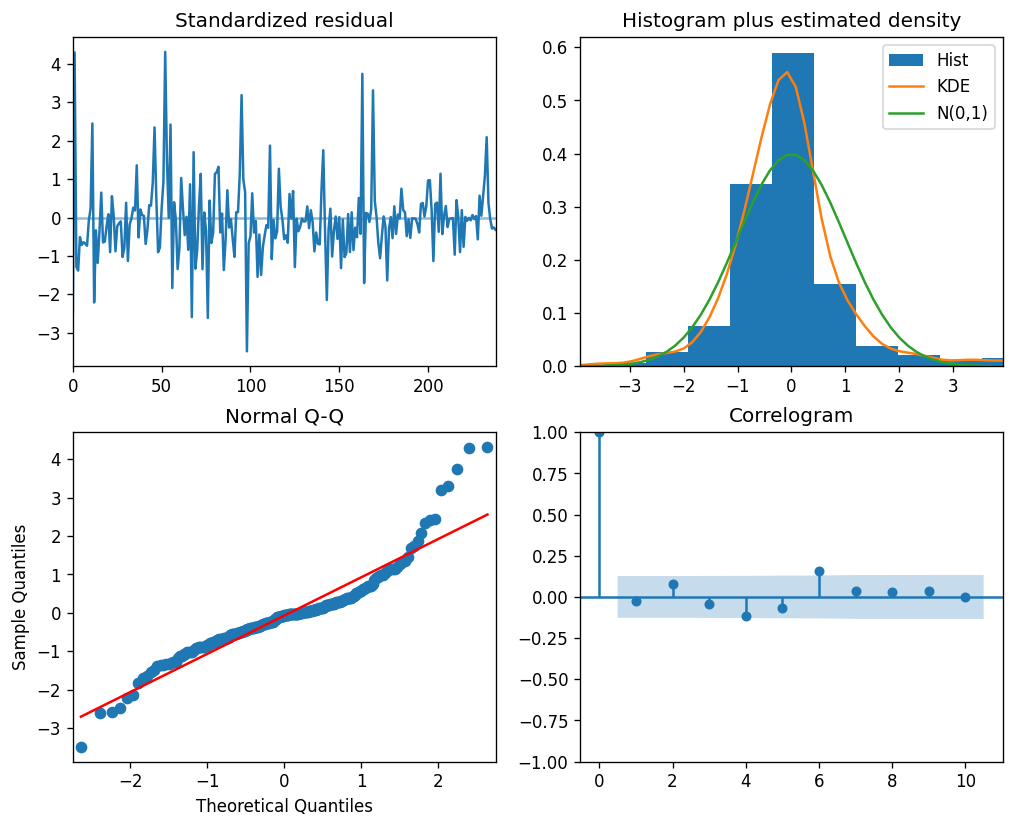

In [ ]:
w_model.plot_diagnostics(figsize=(10,8))
plt.show()

In [ ]:
predict_w = pd.DataFrame(w_model.predict(n_periods = 15),index = test_week.new_index)
predict_w.columns = ['close']

In [ ]:
test_week = test_week.set_index('new_index')

In [ ]:
predict_w

,close
new_index,
240,29.745776
241,29.844257
242,29.883718
243,29.899530
244,29.905866
245,29.908404
246,29.909422
247,29.909829
248,29.909993


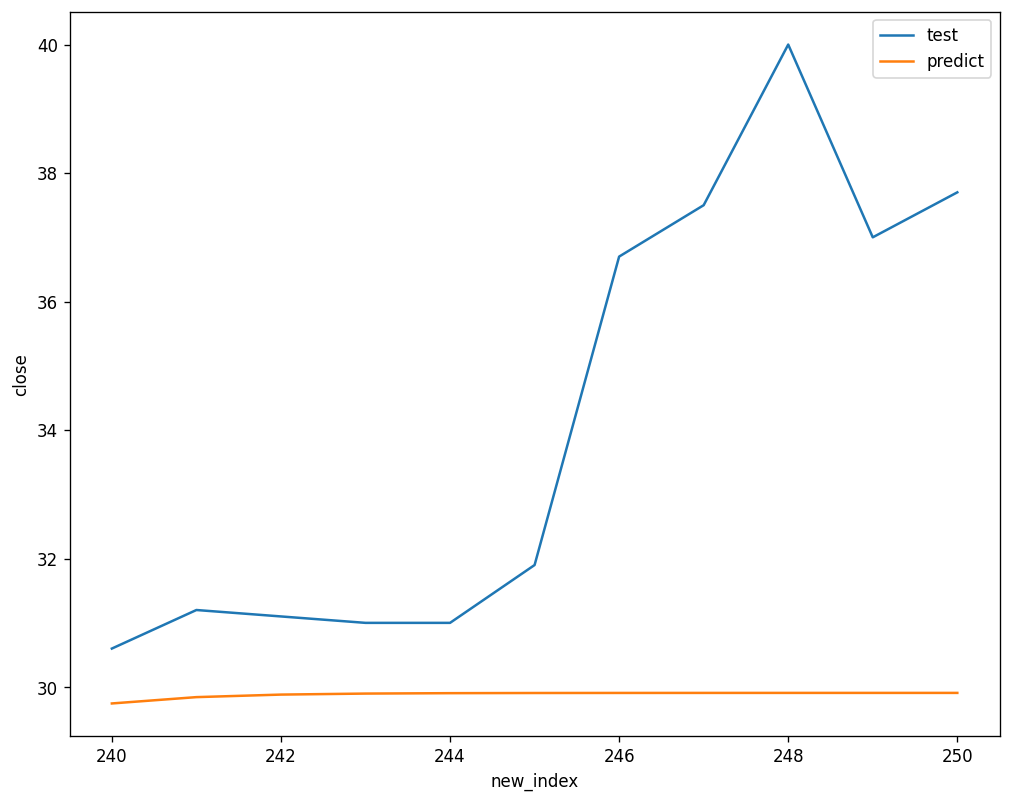

In [ ]:
plt.figure(figsize = (10,8))

sns.lineplot(data = test_week, x = test_week.index, y = 'close',label = 'test')
sns.lineplot(data = predict_w, x = predict_w.index, y='close',label = 'predict')
plt.show()

In [ ]:
print('mape = ',np.mean(np.abs(predict_w.close - test_week.close)/np.abs(test_week.close)))
print('me = ', np.mean(predict_w.close - test_week.close))
print('mae = ', np.mean(np.abs(predict_w.close - test_week.close)))
print('mpe = ', np.mean((predict_w.close - test_week.close)/test_week.close))
print('rmse = ', np.mean((predict_w.close - test_week.close)**2)**.5)
print('corr = ', np.corrcoef(predict_w.close, test_week.close)[0,1])
mins = np.amin(np.hstack([predict_w.close[:,None], test_week.close[:,None]]))
maxs = np.amax(np.hstack([predict_w.close[:,None], 
                              test_week.close[:,None]]))
minmax = 1 - np.mean(mins/maxs)    
print('minmax = ',minmax)

mape =  0.11651247762619182
me =  -4.269369370025242
mae =  4.269369370025242
mpe =  -0.11651247762619182
rmse =  5.451460647692852
corr =  0.5029263259968461
minmax =  0.256355605986626


<ipython-input-205-fc6f9f28d3c0>:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mins = np.amin(np.hstack([predict_w.close[:,None], test_week.close[:,None]]))
<ipython-input-205-fc6f9f28d3c0>:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  maxs = np.amax(np.hstack([predict_w.close[:,None],
<ipython-input-205-fc6f9f28d3c0>:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  test_week.close[:,None]]))
